# Introduction

In this notebook, we go over some visualizations of the iceberg data. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

Now we read in the file. It turns out that "inc_angle" has some bad values, so I convert it to a floating point format with the NaN values left in.

In [2]:
train = pd.read_json('./input/train.json')
test = pd.read_json('./input/test.json')
train['inc_angle'] = pd.to_numeric(train['inc_angle'], errors='coerce')
test['inc_angle'] = pd.to_numeric(test['inc_angle'], errors='coerce')


In [3]:
print('train data size:', len(train['inc_angle']))
print('train inc angles:', np.sum(train['inc_angle'] < 100000))
print('is iceberg:', np.sum(train['is_iceberg']))
print('not iceberg:', np.sum(1 - train['is_iceberg']))

print('test data size:', len(test['inc_angle']))
print('test inc angles:', np.sum(test['inc_angle'] < 100000))


train data size: 1604
train inc angles: 1471
is iceberg: 753
not iceberg: 851
test data size: 8424
test inc angles: 8424


# Global Image Stats

Now we look at some global properties of the images. These are things like the minimum and maximum values, the means, medians, and the 50% mid range of the signal values. There are two different bands used in the file, so I'll do this separately for each band.

In [4]:
def get_stats(train, label=1):
    train['max_band_' + str(label)] = [np.max(np.array(x)) for x in train['band_' + str(label)]]
    train['maxpos_band_' + str(label)] = [np.argmax(np.array(x)) for x in train['band_' + str(label)]]
    train['min_band_' + str(label)] = [np.min(np.array(x)) for x in train['band_' + str(label)]]
    train['minpos_band_' + str(label)] = [np.argmin(np.array(x)) for x in train['band_' + str(label)]]
    train['med_band_' + str(label)] = [np.median(np.array(x)) for x in train['band_' + str(label)]]
    train['std_band_' + str(label)] = [np.std(np.array(x)) for x in train['band_' + str(label)]]
    train['mean_band_' + str(label)] = [np.mean(np.array(x)) for x in train['band_' + str(label)]]

    return train


train = get_stats(train, 1)
train = get_stats(train, 2)


## Plotting the Statistics

Now, we can make some histograms of these variables. I'll make histograms of both classes to see if there are any differences.

In [5]:
def plot_var(name, nbins=50):
    minval = train[name].min()
    maxval = train[name].max()
    plt.hist(train.loc[train.is_iceberg == 1, name], range=[minval, maxval],
             bins=nbins, color='b', alpha=0.5, label='Boat')
    plt.hist(train.loc[train.is_iceberg == 0, name], range=[minval, maxval],
             bins=nbins, color='r', alpha=0.5, label='Iceberg')
    plt.legend()
    plt.xlim([minval, maxval])
    plt.xlabel(name)
    plt.ylabel('Number')
    plt.show()


/Users/nichengzhuo/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/nichengzhuo/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:749: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


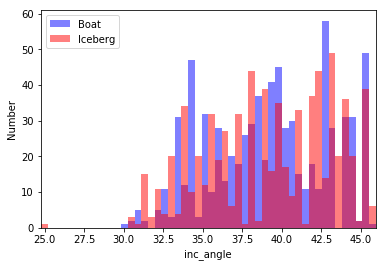

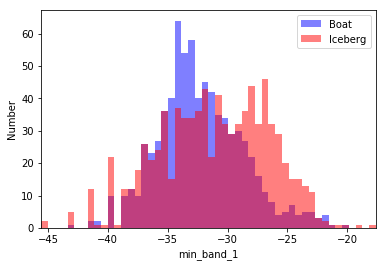

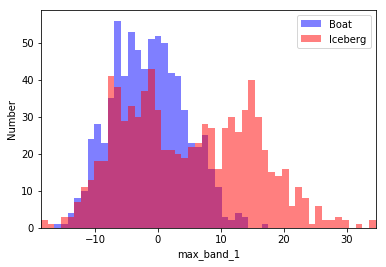

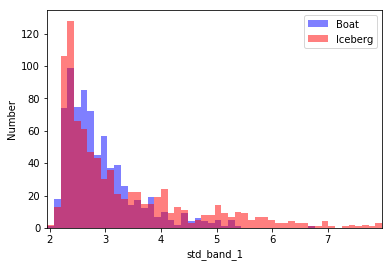

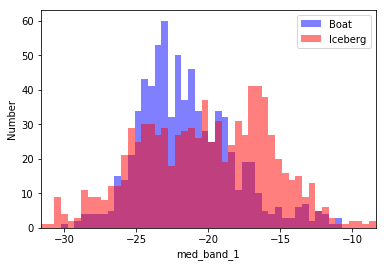

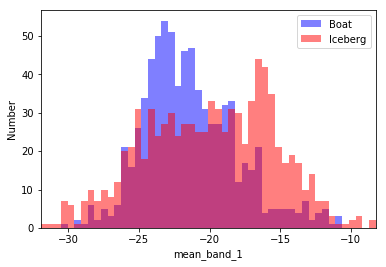

In [6]:
for col in ['inc_angle', 'min_band_1', 'max_band_1', 'std_band_1', 'med_band_1', 'mean_band_1']:
    plot_var(col)


For the first band, we see that there are some significant differences. Evidently, these basic variables seem to have some sensitivity to what we are trying to measure. We might expect this if, for example, icebergs are much larger than ships and thus cover more pixels.

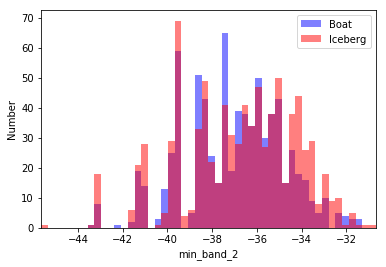

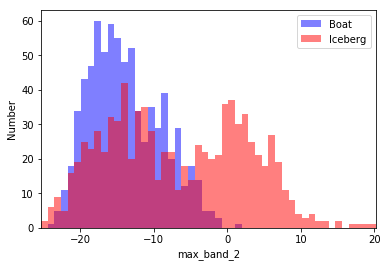

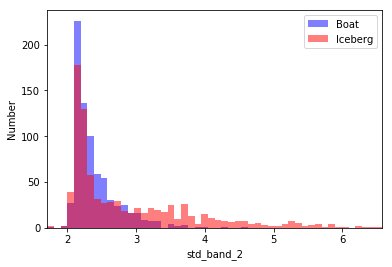

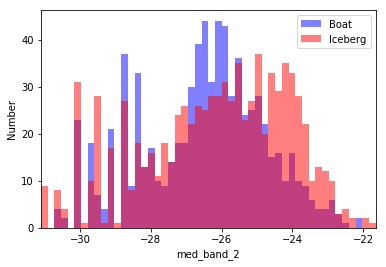

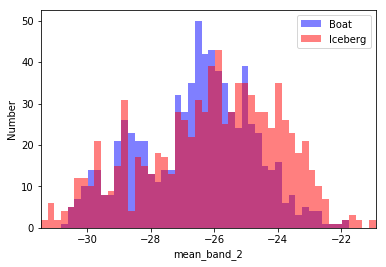

In [7]:
for col in ['min_band_2', 'max_band_2', 'std_band_2', 'med_band_2', 'mean_band_2']:
    plot_var(col)


# Plotting Some Images

In [8]:
icebergs = train[train.is_iceberg == 1].sample(n=9, random_state=123)
ships = train[train.is_iceberg == 0].sample(n=9, random_state=456)


## Raw Images

The first set show 4 random icebergs using band 1.

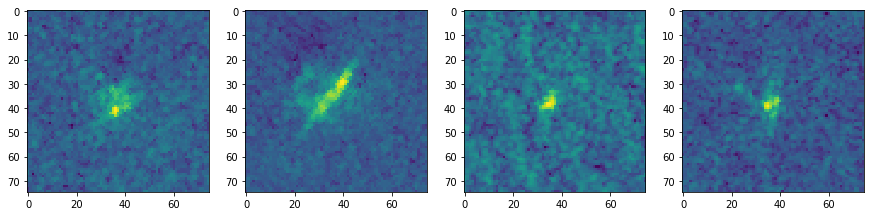

In [9]:
# Plot band_1
fig = plt.figure(1, figsize=(15, 15))
for i in range(4):
    ax = fig.add_subplot(1, 4, i + 1)
    arr = np.reshape(np.array(icebergs.iloc[i, 0]), (75, 75))
    ax.imshow(arr)

plt.show()


The second set shows ships in band 1.

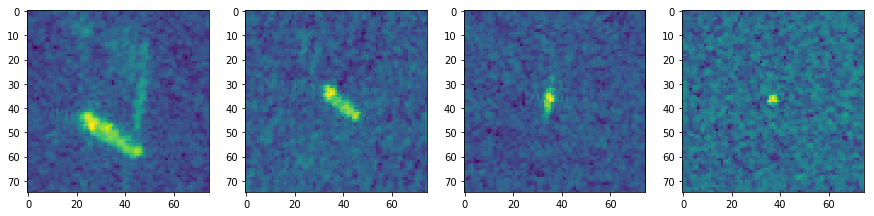

In [10]:
# Plot band_1
fig = plt.figure(1, figsize=(15, 15))
for i in range(4):
    ax = fig.add_subplot(1, 4, i + 1)
    arr = np.reshape(np.array(ships.iloc[i, 0]), (75, 75))
    ax.imshow(arr)

plt.show()


The next set show the same set of icebergs in band 2.

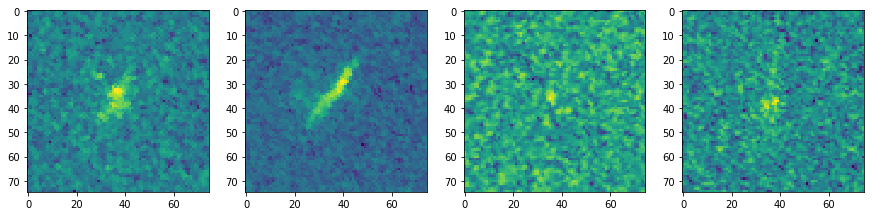

In [11]:
# Plot band_1
fig = plt.figure(1, figsize=(15, 15))
for i in range(4):
    ax = fig.add_subplot(1, 4, i + 1)
    arr = np.reshape(np.array(icebergs.iloc[i, 1]), (75, 75))
    ax.imshow(arr)

plt.show()


Finally, the last set are the same ship images as before, but for band 2.

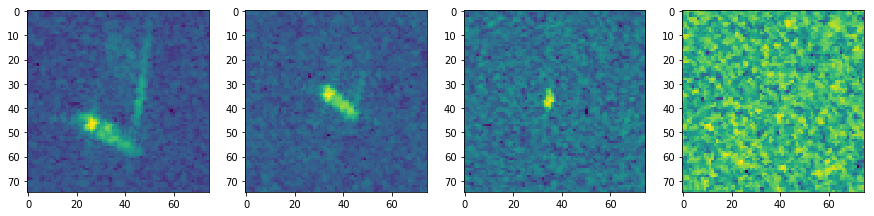

In [12]:
# Plot band_1
fig = plt.figure(1, figsize=(15, 15))
for i in range(4):
    ax = fig.add_subplot(1, 4, i + 1)
    arr = np.reshape(np.array(ships.iloc[i, 1]), (75, 75))
    ax.imshow(arr)

plt.show()


So, we see that everything looks pretty blob-like. It also appears that the background is not really random noise but rather has some spatial correlations. If the background is dominated by things like waves rather than noise, then spatial correlations would clearly be expected. The ships seem to have a more regular structure, with a pronounced skewness in the blobs for larger signals.

Some of these blobs are not that high above noise, and in the last set there are even two images where the signal cannot even be seen by eye, so it may be advantageous to first transform the images in some way to enhance the contrast between the signals and the background.

In [22]:
def rotate(image, angle, center=None, scale=1.0):
    (h, w) = image.shape[:2]

    if center is None:
        center = (w / 2, h / 2)

    M = cv2.getRotationMatrix2D(center, angle, scale)
    rotated = cv2.warpAffine(image, M, (w, h))

    return rotated

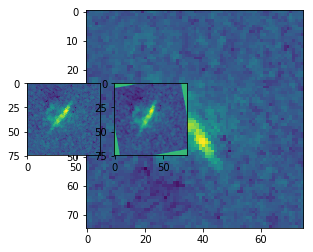

In [39]:
a = np.reshape(icebergs.iloc[1, 0], (75, 75))

a_rot = rotate(a, 10)
plt.imshow(a_rot)

f1_a = cv2.flip(a, 1)
plt.imshow(f1_a)

f2_a = cv2.flip(a, 0)
plt.imshow(f2_a)

fig = plt.figure(1, figsize=(15, 15))

ax = fig.add_subplot(1, 4, 1)
ax.imshow(a)
ax = fig.add_subplot(1, 4, 2)
ax.imshow(a_rot)
ax = fig.add_subplot(1, 4, 3)
ax.imshow(a_rot)
ax = fig.add_subplot(1, 4, 4)
ax.imshow(a_rot)
